In [50]:
from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

import torch
import os
from torch import nn
from sklearn.metrics import average_precision_score
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Train the ExplaiNN model on TF binding sites 

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Parameters
num_epochs = 15
batch_size = 128
learning_rate = 0.001 

dataloaders, target_labels, train_out = tools.load_datas("../tf_peaks_50_sparse_Remap.h5", batch_size,
                                                         0, True)

target_labels = [i.decode("utf-8") for i in target_labels]

num_cnns = 100
input_length = 200
num_classes = len(target_labels)
filter_size = 19

cnn_deep = networks.ConvNetDeep(num_classes)
cnn_shallow = networks.ConvNetShallow(num_classes)
danq = networks.DanQ(num_classes)
explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(explainn.parameters(), lr=learning_rate)

weights_folder = "checkpoints_TFBS"
os.makedirs(weights_folder)
name_ind = ""

Dataset Loaded


In [6]:
# training an individual model with 100 units
explainn, train_error, test_error = train.train_explainn(dataloaders['train'], dataloaders['valid'], explainn,
                                                device, criterion, optimizer, num_epochs,
                                                weights_folder, name_ind, verbose=True, trim_weights=False)

Epoch [1], Current Train Loss: 0.41946, Current Val Loss: 0.39737
Epoch [2], Current Train Loss: 0.39393, Current Val Loss: 0.38686
Epoch [3], Current Train Loss: 0.38654, Current Val Loss: 0.38369
Epoch [4], Current Train Loss: 0.38257, Current Val Loss: 0.38059
Epoch [5], Current Train Loss: 0.37964, Current Val Loss: 0.37969
Epoch [6], Current Train Loss: 0.37788, Current Val Loss: 0.37856
Epoch [7], Current Train Loss: 0.37636, Current Val Loss: 0.37904
Epoch [8], Current Train Loss: 0.37614, Current Val Loss: 0.37801
Epoch [9], Current Train Loss: 0.37482, Current Val Loss: 0.37807
Epoch [10], Current Train Loss: 0.37472, Current Val Loss: 0.37793
Epoch [11], Current Train Loss: 0.37378, Current Val Loss: 0.37784
Epoch [12], Current Train Loss: 0.37286, Current Val Loss: 0.37825
Epoch [13], Current Train Loss: 0.37277, Current Val Loss: 0.37785
Epoch [14], Current Train Loss: 0.37279, Current Val Loss: 0.37797
Epoch [15], Current Train Loss: 0.37260, Current Val Loss: 0.37920


<Figure size 432x288 with 0 Axes>

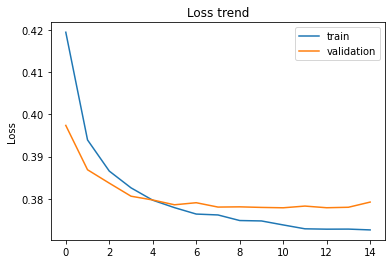

In [7]:
%matplotlib inline
tools.showPlot(train_error, test_error, "Loss trend", "Loss")

In [ ]:
# Code to test how performance depends of the number of units
num_classes = len(target_labels) #number of classes
learning_rate = 0.001

for num_cnns in range(0,205,5):
    if num_cnns == 0:
        num_cnns = 1    

    model = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    os.makedirs("ExplaiNN_filters_TF_binding/ExplaiNN_TF_num_cnns_"+str(num_cnns))
    
    model, train_error, test_error = train.train_explainn(dataloaders['train'], dataloaders['valid'], explainn,
                                                device, criterion, optimizer, num_epochs,
                                                "ExplaiNN_filters_TF_binding/ExplaiNN_TF_num_cnns_"+str(num_cnns)
                                                          , name_ind, verbose=True, trim_weights=False)
    

    print("Numm_cnns: " + str(num_cnns))
    print("Min test error: " + str(np.min(test_error)))

# testing
auprc_perf = {}
num_classes = len(target_labels)
for num_cnns in tqdm(range(0,205,5)):
    if num_cnns == 0:
        num_cnns = 1
    
    model = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
    
    #load the best model
    weight_file = os.listdir("CAM_filters_TF_binding/CAM_TF_num_cnns_"+str(num_cnns)+"/")[0]
    
    model.load_state_dict(torch.load("CAM_filters_TF_binding/CAM_TF_num_cnns_"+str(num_cnns)+"/"+weight_file))
    model.eval();

    labels_E, outputs_E = test.run_test(model, dataloaders['test'], device)
    
    auprc_perf[num_cnns] = average_precision_score(labels_E, outputs_E)
    
auprc_perf = pd.Series(auprc_perf)  

In [15]:
# performances for individual TFs (classes)
explainn.eval();
labels_E, outputs_E = test.run_test(explainn, dataloaders['test'], device)

no_skill_probs = [0 for _ in range(len(labels_E[:,0]))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(labels_E[:,0], no_skill_probs)

roc_aucs = {}
raw_aucs = {}
roc_prcs = {}
raw_prcs = {}
for i in range(len(target_labels)):
    nn_fpr, nn_tpr, threshold = metrics.roc_curve(labels_E[:,i], outputs_E[:,i])
    roc_auc_nn = metrics.auc(nn_fpr, nn_tpr)
    
    precision_nn, recall_nn, thresholds = metrics.precision_recall_curve(labels_E[:,i], outputs_E[:,i])
    pr_auc_nn = metrics.auc(recall_nn, precision_nn)
    
    roc_aucs[target_labels[i]] = nn_fpr, nn_tpr
    raw_aucs[target_labels[i]] = roc_auc_nn
    
    roc_prcs[target_labels[i]] = recall_nn, precision_nn
    raw_prcs[target_labels[i]] = pr_auc_nn
    
raw_prcs_explainn = pd.Series(raw_prcs)
raw_aucs_explainn = pd.Series(raw_aucs)

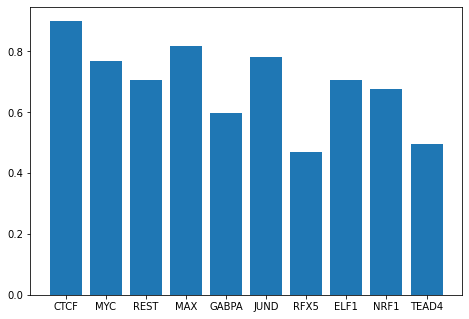

In [16]:
# AUPRC
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
TFs = raw_prcs_explainn.index[:10]
AUPRC = raw_prcs_explainn.values[:10]
ax.bar(TFs,AUPRC)
plt.show()

# Interpretation

In [36]:
explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)

weight_file = os.listdir(f"../CAM_filters_TF_binding/CAM_TF_num_cnns_{num_cnns}/")[0]
explainn.load_state_dict(torch.load(f"../CAM_filters_TF_binding/CAM_TF_num_cnns_{num_cnns}/"+weight_file))
explainn.eval();

In [37]:
explainn

ExplaiNN(
  (linears): Sequential(
    (0): Conv1d(400, 100, kernel_size=(19,), stride=(1,), groups=100)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): exp_activation_module()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(2600, 10000, kernel_size=(1,), stride=(1,), groups=100)
    (7): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(10000, 100, kernel_size=(1,), stride=(1,), groups=100)
    (11): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=100, out_features=50, bias=True)
)

In [52]:
dataset, data_inp, data_out = tools.load_single_data("../tf_peaks_50_sparse_Remap.h5", batch_size, 0, False)
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=True)

# only well predicted sequences
pred_full_round = np.round(predictions)
arr_comp = np.equal(pred_full_round, labels)
idx = np.argwhere(np.sum(arr_comp, axis=1) == len(target_labels)).squeeze()

data_inp = data_inp[idx, :, :]
data_out = data_out[idx, :]

dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, shuffle=False,
                                                  num_workers=0)

activations = interpretation.get_explainn_unit_activations(data_loader, explainn, device)
pwms = interpretation.get_pwms_explainn(activations, data_inp, data_out, filter_size)
interpretation.pwm_to_meme(pwms, "data/TFBS.meme")

100%|██████████| 82/82 [00:00<00:00, 137.69it/s]


In [ ]:
%%bash
. ~/.bashrc
./../../../meme-5.3.3/src/tomtom -oc ../../../tomtom_results/tomtom_TF_binding/tomtom_CAM_$num_cnns data/TFBS.meme ../../../tomtom_results/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt

In [39]:
tomtom_results = pd.read_csv(f"../../../tomtom_results/tomtom_TF_binding/tomtom_CAM_{num_cnns}/tomtom.tsv",
                                        sep="\t",comment="#")

filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]

tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]

cisbp_motifs = {}
with open("../../../tomtom_results/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([cisbp_motifs[i] for i in target_id.values])
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation

filter0                               TEAD2/TEAD4/TEAD1/TEAD3
filter1                                                ZBTB14
filter4                             Ar/NR3C1/NR3C2/NR1I2/ESR2
filter5                                                PHOX2B
filter6                                                  CTCF
filter8                         FOXC2/FOXD2/Foxl2/FOXC1/FOXA2
filter12                                MYC/MAX/HES1/MNT/MYCN
filter13                                            MAFG/MAFF
filter14                                    Zfx/TFAP2C(var.2)
filter15        NFIC(var.2)/NFIX(var.2)/Foxl2/NFIB/NFIC::TLX1
filter18                                     FOSL1::JUND/Pax2
filter19                        FOXA1/FOXC1/FOXA2/FOXB1/FOXA3
filter21                                                 CTCF
filter25                                        MAF/MAFA/MAFK
filter28                          MITF/USF1/USF2/BHLHE41/TFEB
filter29                                                 CTCF
filter32

In [40]:
weights = explainn.final.weight.detach().cpu().numpy()

filters = ["filter"+str(i) for i in range(num_cnns)]
for i in annotation.keys():
    filters[int(i.split("filter")[-1])] = annotation[i]
    
weight_df = pd.DataFrame(weights,index=target_labels,columns=filters)
weight_df.shape

(50, 100)

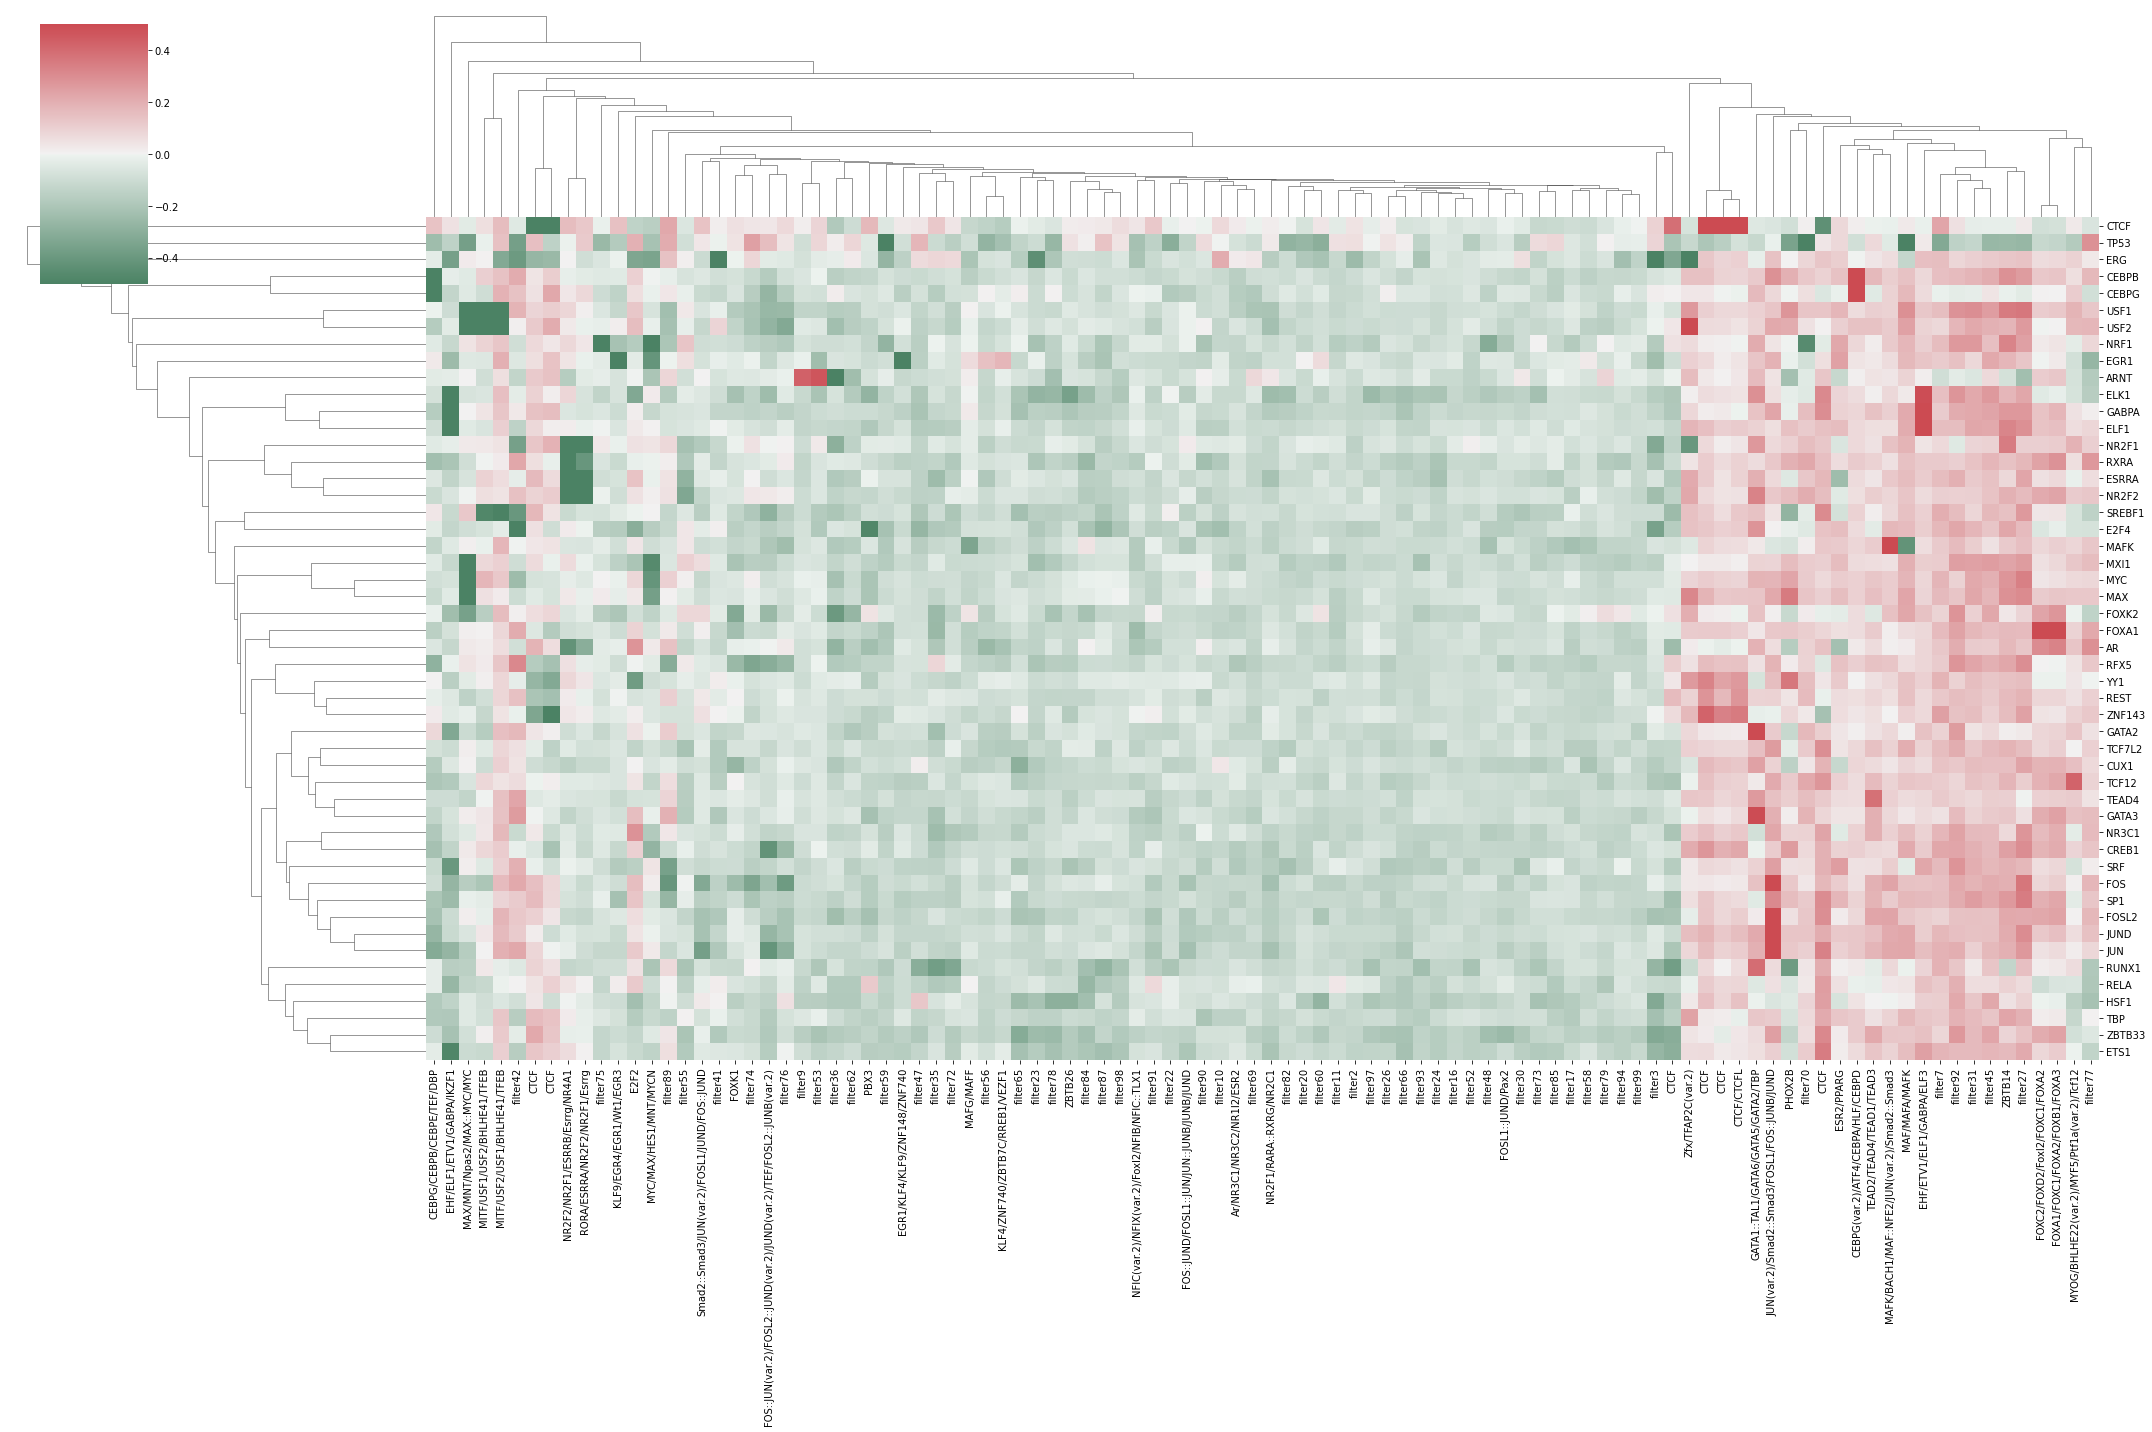

In [42]:
sns.clustermap(weight_df,cmap=sns.diverging_palette(145, 10, s=60, as_cmap=True), 
               row_cluster=True, figsize=(30,20), vmax=0.5, vmin = -0.5)

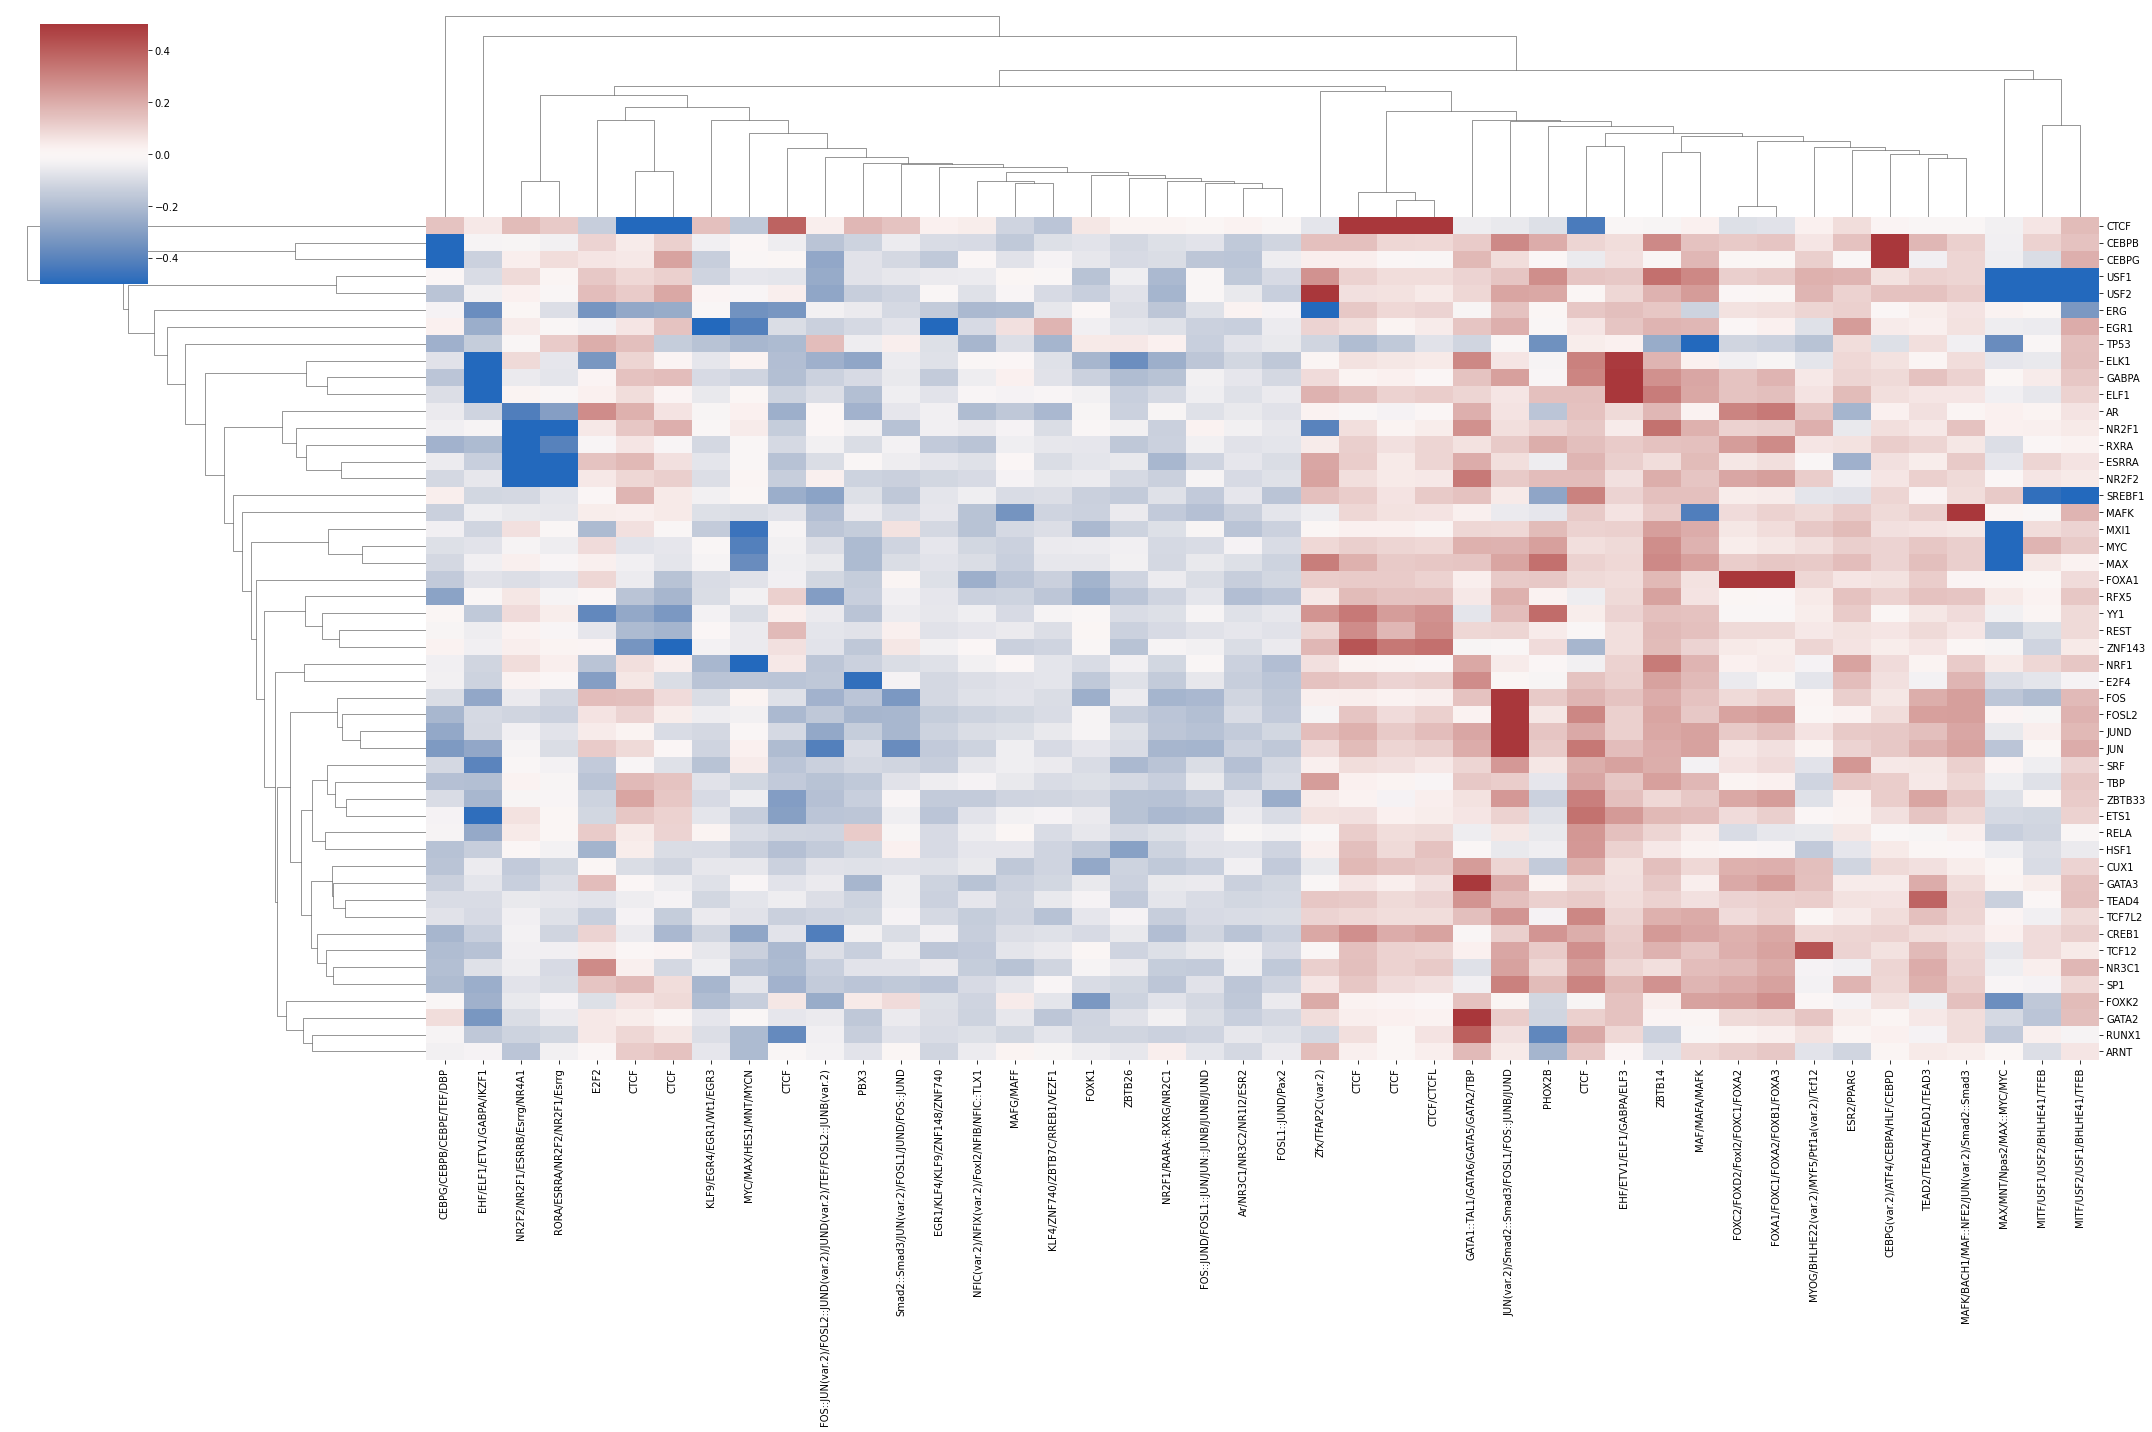

In [43]:
#only annotated columns
ann_wdf = weight_df.loc[:,["filter" not in i for i in list(weight_df)]]

clust = sns.clustermap(ann_wdf, cmap='vlag',#cmap=sns.diverging_palette(145, 10, s=60, as_cmap=True), 
               row_cluster=True, figsize=(30,20), vmax=0.5, vmin = -0.5)

## Importance scores

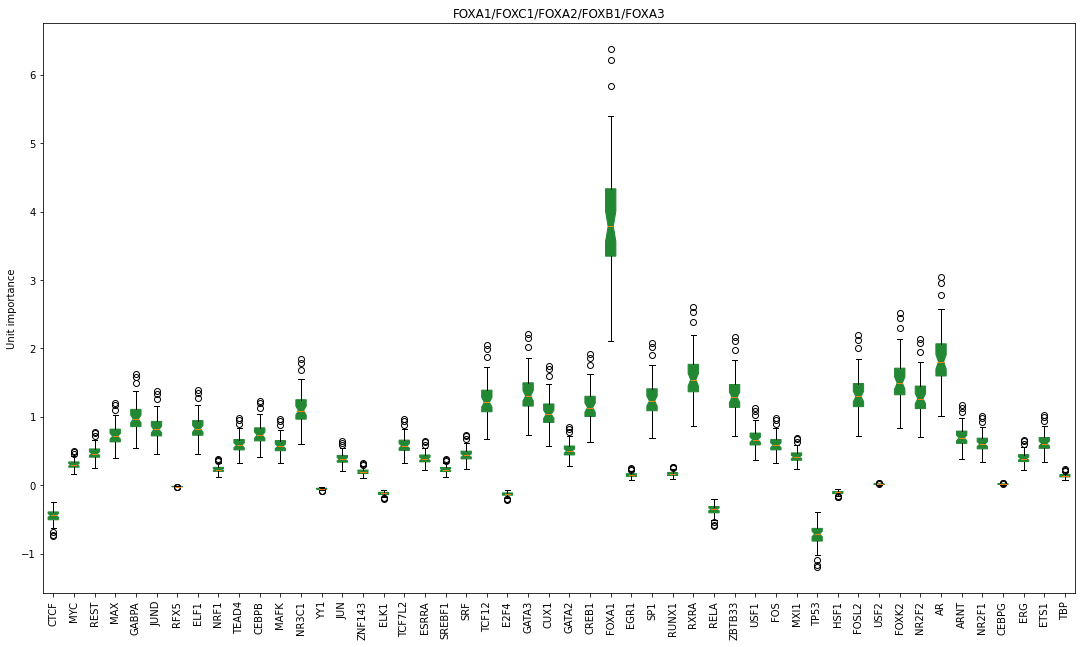

In [56]:
unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)

unit_importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, 19, target_labels)

filter_key = "filter"+str(19)
title = annotation[filter_key] if filter_key in annotation.index else filter_key
fig, ax = plt.subplots()
datas = [filt_dat for filt_dat in unit_importance]
ax.boxplot(datas, notch=True, patch_artist=True, boxprops=dict(facecolor="#228833", color="#228833"))
fig.set_size_inches(18.5, 10.5)
plt.title(title)
plt.ylabel("Unit importance")
plt.xticks(range(1, len(target_labels)+1), target_labels)
plt.xticks(rotation=90)
plt.show()